# EDA IBM stock 1min ticks

## Takeouts -  december 29/2019
* The distribution of the difference of the time series has very long tails: see plot. This was expected; still very ugly.
* Created a very clean dataset with 'pastValues', 'currentValue', 'futureValue', 'deltaMinutes'. 
* The precision recall curve that we already have looks quite good: we trained one single time.

## Takeouts -  december 30/2019
* Plot a precision recall curve with several(monthly/weekly) training batches

## To do

* There is a delicate issue about rescaling before training that needs to be fixed asap.
* Turn the code that produces the 'clean' data set into a more reusable one
* The current version of the target is not very realistic.
* Need a more elaborated way of looking at histograms: the tails don't let me see anything: those tails are a huge concern.
* Look out for sklearn methods to do crossvalidation in our setting: do not reinvent the wheel.

## Questions to Jake:
* Data provider (currently using sample (adjusted) data from Kibot): he uses polygon
* How can I authomatize making orders, is there an api? how does this even work in real life? he mentioned 'efficient frontier'
* Cost per order (0.5 cents per share or 2 dollars per trade)
* Latency issues to be aware of.
* How/at what point can we know if we are `moving the market` too much? In the afternoon there is very little volume.


## Notes from Jake
* Tick data might be more useful for quant analysis.
* polygon.io source of data.
* thinkorswim.com: 2 dollars per trade, 
* interactivebrokers : half a cent per share.
* kelly criterion?
* ibridgepy ... take quantopian to real life.
* zipline - quantopian type of thing.
* efficient frontier. for blending the strategies.
* kygo: his thing.
* Use quantopian!

In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [2]:
from modeling.dataSetUtilities import createTrainingDataSet
from modeling.generatePipeline import generatePipeline

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier ## might not be necessary in the future?

In [4]:
names = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_csv('data/sampleKibotData/minuteIntraday/IBM_adjusted.txt', header=None, names=names, nrows=10000)
df['DateTime']= pd.to_datetime((df.Date+' '+df.Time),infer_datetime_format=True) 
df = df.drop(columns=['Date', 'Time'])
df = df.set_index('DateTime')

In [5]:
df.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
1998-01-02 09:30:00,33.69,33.69,33.69,33.69,207820
1998-01-02 09:31:00,33.65,33.69,33.65,33.65,33499
1998-01-02 09:32:00,33.67,33.69,33.65,33.69,41254
1998-01-02 09:33:00,33.67,33.69,33.65,33.65,52110
1998-01-02 09:34:00,33.65,33.69,33.65,33.65,14892


In [6]:
#df.head()
#df.Open.plot(figsize=(15,5), title='IBM stock');
#df.index.map(lambda x: x.year).value_counts().sort_index().plot.bar(figsize=(15, 5), title='ticks per year');
#df.Open.diff().plot.hist(bins=200, figsize=(15,5), title= 'distribution of the differential');
#pd.Series(df.index.map(lambda x: x.day)).value_counts().sort_index().plot.bar()

In [20]:
dg= createTrainingDataSet(df, numPastMins=1, numFutureMins=10)
X = dg.copy()
y = X.pop('target')

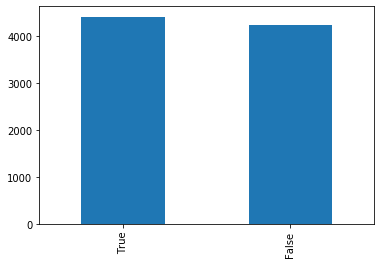

In [21]:
y.value_counts().plot.bar()

In [22]:
trivial = [[1] for _ in range(len(X))]
X.Open = trivial
#X.High = trivial
X.Low=trivial
X.Close = trivial
X.Volume = trivial

In [34]:
# we might have some sort of overfiting(???)
X

,Open,High,Low,Close,Volume
DateTime,,,,,
1998-01-02 09:30:00,[1],[33.69],[1],[1],[1]
1998-01-02 09:31:00,[1],[33.69],[1],[1],[1]
1998-01-02 09:32:00,[1],[33.69],[1],[1],[1]
1998-01-02 09:33:00,[1],[33.69],[1],[1],[1]
1998-01-02 09:34:00,[1],[33.69],[1],[1],[1]
...,...,...,...,...,...
1998-02-09 13:30:00,[1],[31.88],[1],[1],[1]
1998-02-09 13:31:00,[1],[31.92],[1],[1],[1]
1998-02-09 13:32:00,[1],[31.9],[1],[1],[1]


## A precision recall-curve with only one training split.

In [24]:
# temporal split of train/test
trainPercentage = 50
testBegins = (len(X)*trainPercentage)//100
Xtrain, ytrain = X[:testBegins], y[:testBegins]
Xtest, ytest = X[testBegins:], y[testBegins:]

In [25]:
model = generatePipeline()
model.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('selectcolumns',
                 ColumnSelector(columns=['Open', 'High', 'Low', 'Close',
                                         'Volume'])),
                ('scaletimeseries',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function timeSeriesScaler at 0x11ef88158>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('featurengineering',
                 FunctionTransformer(accept_spars...
                ('scaler',
                 TransformationWrapper(transformation=MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1)))),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,

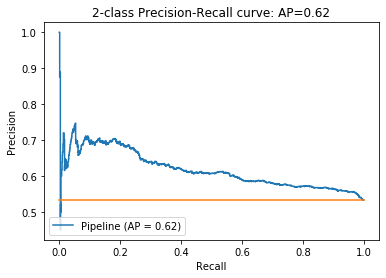

In [26]:
base_rate = sum(ytest)/len(ytest)
ypredicted=model.predict_proba(Xtest)[:,1]
average_precision = average_precision_score(ytest, ypredicted)
disp = plot_precision_recall_curve(model, Xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([0, 1], [base_rate, base_rate]);

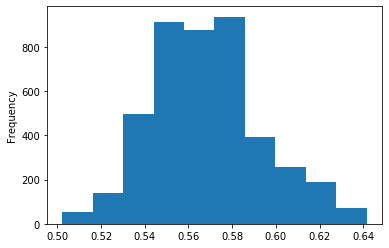

In [33]:
pd.Series(ypredicted).plot.hist()

In [27]:
## now lets do the same but predict when performance is going to be below median
ytrain_neg = ~(ytrain)
ytest_neg = ~(ytest)
model = generatePipeline()
model.fit(Xtrain, ytrain_neg)


Pipeline(memory=None,
         steps=[('selectcolumns',
                 ColumnSelector(columns=['Open', 'High', 'Low', 'Close',
                                         'Volume'])),
                ('scaletimeseries',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function timeSeriesScaler at 0x11ef88158>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('featurengineering',
                 FunctionTransformer(accept_spars...
                ('scaler',
                 TransformationWrapper(transformation=MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1)))),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,

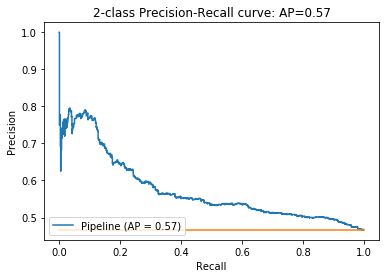

In [28]:
base_rate = sum(ytest_neg)/len(ytest_neg)
ypredicted_neg=model.predict_proba(Xtest)[:,1]
average_precision = average_precision_score(ytest_neg, ypredicted_neg)
disp = plot_precision_recall_curve(model, Xtest, ytest_neg)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([0, 1], [base_rate, base_rate]);

# A precision-recall curve with multiple training batches

In [ ]:
X = pd.concat([dg.pastValues.apply(lambda x:pd.Series(x)), dg.currentValue, dg.target], axis=1)
firstTimeStamp=X.index[0]
first_day = datetime(firstTimeStamp.year, firstTimeStamp.month, firstTimeStamp.day)
X['week']=pd.Series(X.index).apply(lambda x: (datetime(x.year, x.month, x.day)-first_day).days//7).values

In [ ]:
# notice that for the week zero we wont have a model.
trainSets = [X[X.week==w] for w in X.week.unique()]
trainTestBarches = [(None, None, None, None)]+[(trainSets[i].drop(columns='target'),trainSets[i].target,trainSets[i+1].drop(columns='target'),trainSets[i+1].target) for i in range(len(trainSets)-1)]
models = [None] + [GridSearchCV(regr, parameters, cv=2, scoring='average_precision') for _ in range(len(trainSets)-1)]

In [ ]:
Xtrain, ytrain, Xtest, ytest = trainTestBarches[1]

In [ ]:
Xtrain # notice: week should not be in the model, but its ok for now

In [ ]:
for i in range(1, len(models)):
    print(i)
    Xtrain, ytrain, Xtest, ytest = trainTestBarches[i]
    models[i].fit(Xtrain.div(Xtrain.currentValue, axis=0), ytrain)

In [ ]:
# this function is worth saving somewhere !
def indexedModelEvaluation(x):
    row = x.copy()
    week = row['week']
    row = row.drop('target')
    row = [list(row/row.currentValue)]
    model = models[week]
    return np.nan if model==None else model.predict_proba(row)[0][1]

In [ ]:
ypredicted = X.apply(indexedModelEvaluation,axis=1)

In [ ]:
X['predicted']=ypredicted

In [ ]:
dh = X[['predicted', 'target']].copy()

In [ ]:
dh = dh[dh.predicted.notna()] 

In [ ]:
ytest = dh.target
ypredicted = dh.predicted
base_rate = sum(ytest)/len(ytest)
average_precision = average_precision_score(ytest, ypredicted)
precision, recall, _ = precision_recall_curve(ytest, ypredicted)

In [ ]:
plt.plot(recall, precision)
plt.plot([0, 1], [base_rate, base_rate]);